In [3]:
# Load required modules
import numpy as np
from datetime import date
from matplotlib import pyplot as plt
from cmocean import cm
import datetime as dt
import pandas as pd
import xarray as xr
from xml.dom import minidom
import urllib, requests
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from thredds_crawler.crawl import Crawl
from erddapy import ERDDAP
%pylab inline
from oceans import filters
from scipy import signal, stats
import io
import requests

Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['cm', 'e']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


__MBA Seawaterintake timeseries__

This data can be pulled from ERDDAP going back to 1995 (for Temperature). Here are the processing steps:
1. Pull Data
2. Remoive erronious temperature data (< 40 degees F and > 60 degrees F)
3. Resample to hourly data
3. Convert to degrees Celcius
4. Run a Tidal Filter (40-hour) over temperature.

In [93]:
def get_erddap_data(cencoos_erddap_id):
    e = ERDDAP(
      server='http://erddap.cencoos.org/erddap/',
      protocol='tabledap',
    )
    e.dataset_id = cencoos_erddap_id
    url = e.get_download_url()
    
    df = e.to_pandas(
        index_col='time (UTC)',
        parse_dates=True)
    # Clean up data
    df.sort_index(inplace=True) # make data ascending in time, easier for plotting
    df_temp = df[(df['sea_water_temperature (degree_Fahrenheit)'] > 40)&(df['sea_water_temperature (degree_Fahrenheit)'] < 70)]
    df_temp = df_temp.tz_convert(None); #remove timezone information 
    df_temp['seawater_temp_C'] = (df_temp['sea_water_temperature (degree_Fahrenheit)'] -32) * (5/9)
    return(df_temp)


In [94]:
dataset_id = "org_montereybayaquarium_intake_1"
df_mba = get_erddap_data(dataset_id)
df_mba.head()

,latitude (degrees_north),longitude (degrees_east),station,sea_water_temperature (degree_Fahrenheit),fractional_saturation_of_oxygen_in_sea_water (%),sea_water_ph_reported_on_total_scale (1),sea_water_electrical_conductivity (mS.cm-1),depth (m),seawater_temp_C
time (UTC),,,,,,,,,
1995-09-22 08:09:50,36.618553,-121.901536,Monterey Bay Aquarium Seawater Intake,57.362,NaN,NaN,NaN,0.0,14.09
1995-09-22 08:14:50,36.618553,-121.901536,Monterey Bay Aquarium Seawater Intake,57.326,NaN,NaN,NaN,0.0,14.07
1995-09-22 08:19:50,36.618553,-121.901536,Monterey Bay Aquarium Seawater Intake,57.344,NaN,NaN,NaN,0.0,14.08
1995-09-22 08:24:50,36.618553,-121.901536,Monterey Bay Aquarium Seawater Intake,57.344,NaN,NaN,NaN,0.0,14.08
1995-09-22 08:29:49,36.618553,-121.901536,Monterey Bay Aquarium Seawater Intake,57.308,NaN,NaN,NaN,0.0,14.06


__Filter tidal data out__

Text(0.5,0,'n-window')

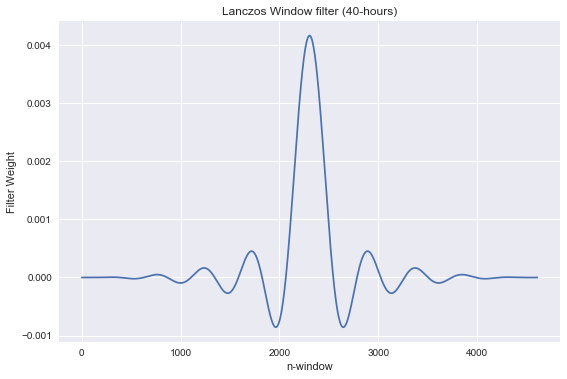

In [95]:
# 40 hour low pass filter
wt = filters.lanc((96*12)+1+(96*12), 1/(40*12.)) # Lanczos filter 
df_mba['low_pass_temp'] = np.convolve(wt, df_mba['seawater_temp_C'].values, mode='same')
fig, ax = plt.subplots()
ax.plot(wt) # Plot Filter window
ax.set_title('Lanczos Window filter (40-hours)')
ax.set_ylabel('Filter Weight')
ax.set_xlabel('n-window')

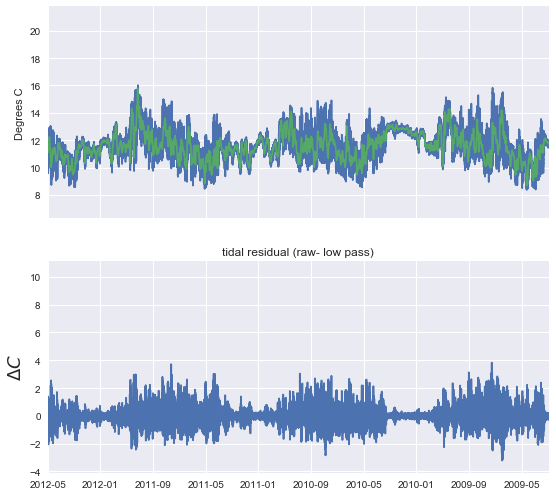

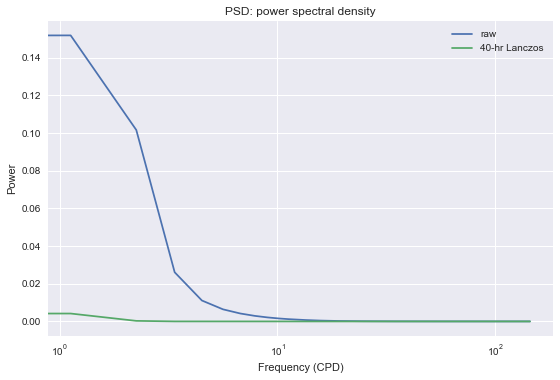

In [96]:
fig, (ax, ax2) = plt.subplots(2,sharex=True)
fig.set_size_inches(8,8)
ax.plot(df_mba['seawater_temp_C'])
ax.plot(df_mba['low_pass_temp'])
# ax.set_ylim(8,13)
ax.set_xlim('2012-5-1','2009-3-1')
ax.set_ylabel('Degrees C')
ax2.plot(df_mba['seawater_temp_C'] - df_mba['low_pass_temp'])
ax2.set_title('tidal residual (raw- low pass)')
ax2.set_ylabel('$\Delta C$',size=18)
sig = df_mba['seawater_temp_C'].dropna().values # remove all NaNs
freqs, psd = signal.welch(sig,fs=24*12)
fig,(ax) = plt.subplots()
ax.semilogx(freqs, psd,label='raw')
plt.title('PSD: power spectral density')
plt.xlabel('Frequency (CPD)')
plt.ylabel('Power')
plt.tight_layout()
sig = df_mba['low_pass_temp'].dropna().values # remove all NaNs
freqs, psd = signal.welch(sig,fs=24*12)
ax.semilogx(freqs, psd,label='40-hr Lanczos')
plt.title('PSD: power spectral density')
plt.legend()

__Hopkins Marine Station Daily Seawater Temperature Record__

In [97]:
url = 'http://scripps.ucsd.edu/programs/shorestations/wp-content/uploads/sites/96/2017/07/PG_1919-201502.txt'
# s=requests.get(url).content
# c=pd.read_csv(io.StringIO(s.decode('utf-8')))
hms_df = pd.read_csv(url,delimiter='\t',skiprows=28,)
hms_df = hms_df.convert_objects( convert_numeric=True)
hms_df['DATE'] = pd.to_datetime(hms_df.YEAR.astype(str)+ hms_df.MONTH.astype(str) +hms_df.DAY.astype(str),format='%Y%m%d')
hms_df.index = hms_df['DATE']
hms_df.sort_index(inplace=True)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """


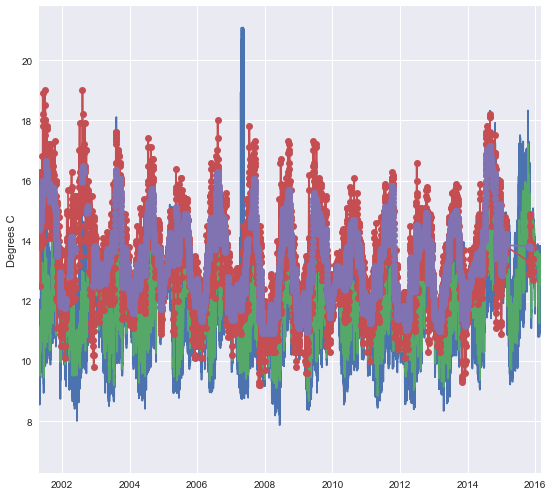

In [98]:
fig, (ax) = plt.subplots()
fig.set_size_inches(8,8)
ax.plot(df_mba['seawater_temp_C'])
ax.plot(df_mba['low_pass_temp'])
# ax.set_ylim(8,13)
ax.plot(hms_df['DATE'], hms_df['SURF_TEMP_C'],marker='o')
ax.set_xlim('2001-5-1','2016-3-1')
ax.set_ylabel('Degrees C')
ax.plot(hms_df['SURF_TEMP_C'].rolling(window=30,win_type='hamming',center=True).mean(),marker='o')


In [99]:
hms_time = hms_df[np.isfinite(hms_df['TIME'])]
hms_time['TIME'] = hms_time['TIME'].astype(int).astype(str).apply(lambda x: '0'+x if len(x) == 3 else x) # add leading zero to time string
hms_time['dateTime'] = pd.to_datetime(hms_time.YEAR.astype(str)+ hms_time.MONTH.astype(str) +hms_time.DAY.astype(str)+" "+hms_time['TIME'],format='%Y%m%d %H%M');
hms_time.index = hms_time['dateTime'];

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [100]:
# Convert to UTC, then remove timezone awareness for ease of manipulation
hms_time = hms_time.tz_localize('US/Pacific')
hms_time = hms_time.tz_convert('UTC')
hms_time = hms_time.tz_convert(None); #remove timezone information 

__Resample MBA temperature to get nearest temperature estimates to HMS data__

In [101]:
hmsIndex = hms_time.index
mba_daily = df_mba.reindex(hmsIndex,method='nearest')

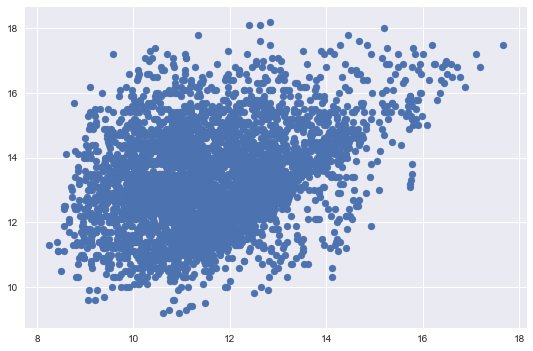

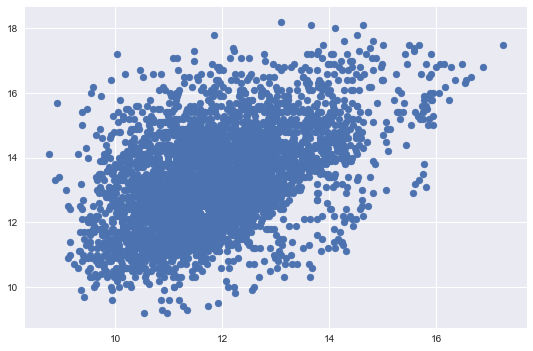

In [102]:
fig, ax = plt.subplots()
ax.scatter(mba_daily['seawater_temp_C'], hms_time['SURF_TEMP_C'])
fig, ax = plt.subplots()
ax.scatter(mba_daily['low_pass_temp'], hms_time['SURF_TEMP_C'])

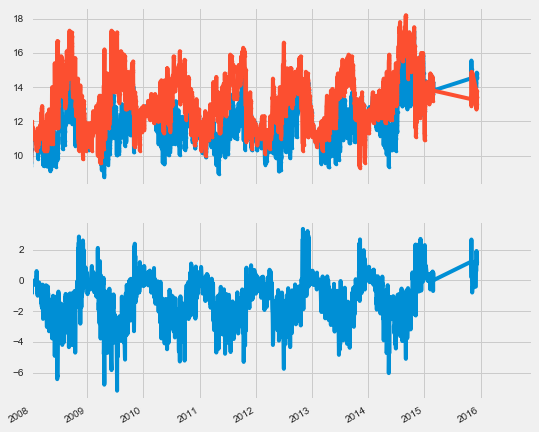

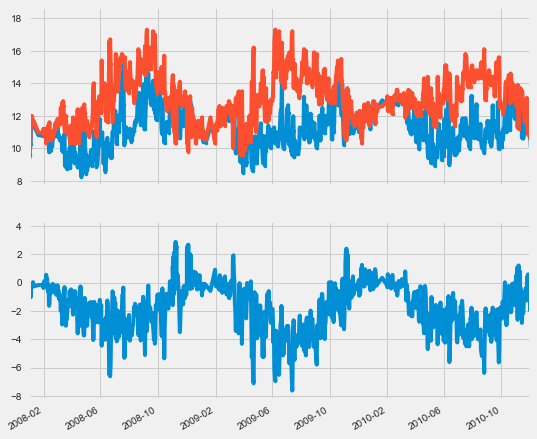

In [103]:
plt.style.use('fivethirtyeight')
fig, (ax,ax2) = plt.subplots(2,sharex=True)
fig.set_size_inches(8,8)
ax.plot(mba_daily['low_pass_temp'],marker='.')
ax.plot(hms_time['SURF_TEMP_C'],marker='.')
ax.set_xlim('2008-1-1','2016-12-1')
ax2.plot(mba_daily['low_pass_temp'] - hms_time['SURF_TEMP_C'])
fig.autofmt_xdate()


plt.style.use('fivethirtyeight')
fig, (ax,ax2) = plt.subplots(2,sharex=True)
fig.set_size_inches(8,8)
ax.plot(mba_daily['seawater_temp_C'],marker='.')
ax.plot(hms_time['SURF_TEMP_C'],marker='.')
ax.set_xlim('2008-1-1','2010-12-1')
ax2.plot(mba_daily['seawater_temp_C'] - hms_time['SURF_TEMP_C'])
fig.autofmt_xdate()


__Get CDIP wave buoy data off of HMS__

In [104]:
dataset_id = "edu_ucsd_cdip_46240"
df_cdip = get_erddap_data(dataset_id)

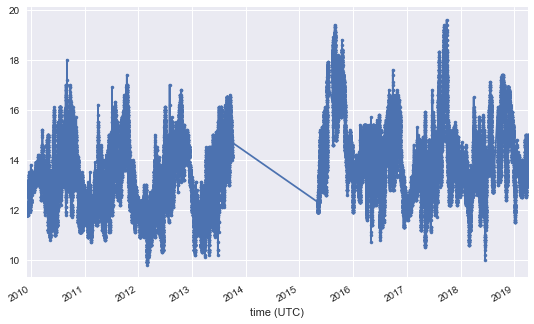

In [105]:
plt.style.use('seaborn')
df_cdip_temp['seawater_temp_C'].plot(marker='.')

Text(0.5,0,'n-window')

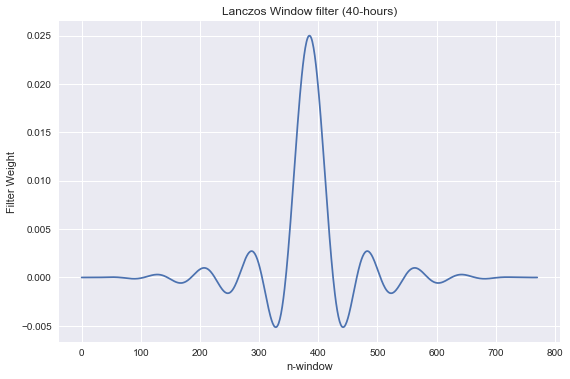

In [106]:
# 40 hour low pass filter
wt = filters.lanc((96*2)+1+(96*2), 1/(40*2.)) # Lanczos filter 
df_cdip_temp['low_pass_temp'] = np.convolve(wt, df_cdip_temp['seawater_temp_C'].values, mode='same')
fig, ax = plt.subplots()
ax.plot(wt) # Plot Filter window
ax.set_title('Lanczos Window filter (40-hours)')
ax.set_ylabel('Filter Weight')
ax.set_xlabel('n-window')

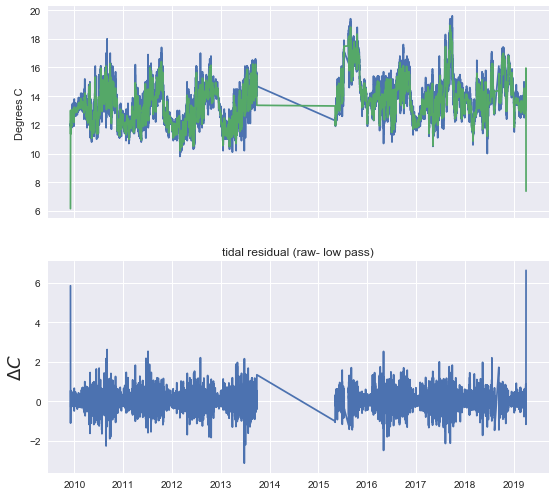

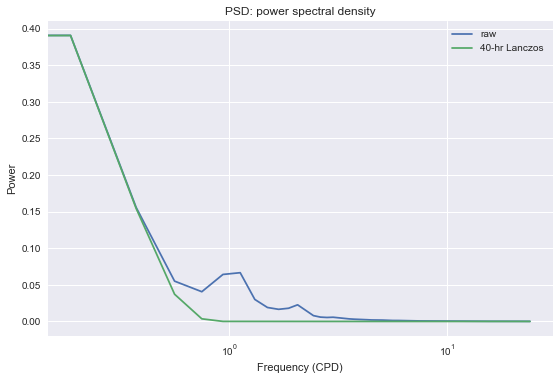

In [37]:
fig, (ax, ax2) = plt.subplots(2,sharex=True)
fig.set_size_inches(8,8)
ax.plot(df_cdip_temp['seawater_temp_C'])
ax.plot(df_cdip_temp['low_pass_temp'])
# ax.set_ylim(8,13)
# ax.set_xlim('2012-5-1','2009-3-1')
ax.set_ylabel('Degrees C')
ax2.plot(df_cdip_temp['seawater_temp_C'] - df_cdip_temp['low_pass_temp'])
ax2.set_title('tidal residual (raw- low pass)')
ax2.set_ylabel('$\Delta C$',size=18)
sig = df_cdip_temp['seawater_temp_C'].dropna().values # remove all NaNs
freqs, psd = signal.welch(sig,fs=24*2)
fig,(ax) = plt.subplots()
ax.semilogx(freqs, psd,label='raw')
plt.title('PSD: power spectral density')
plt.xlabel('Frequency (CPD)')
plt.ylabel('Power')
plt.tight_layout()
sig = df_cdip_temp['low_pass_temp'].dropna().values # remove all NaNs
freqs, psd = signal.welch(sig,fs=24*2)
ax.semilogx(freqs, psd,label='40-hr Lanczos')
plt.title('PSD: power spectral density')
plt.legend()

0.9008198479356966 0.8501320449618427


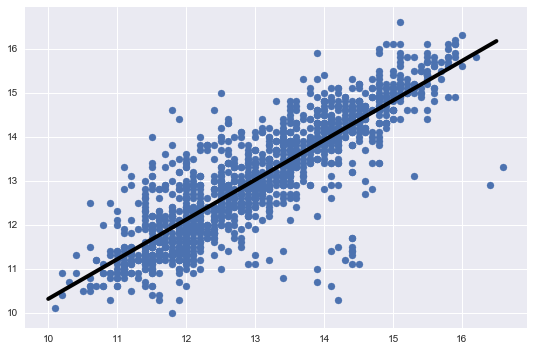

In [88]:
cdip_daily = df_cdip_temp.reindex(hms_time.sort_index().index ,method='nearest',limit=2)
fig, ax = plt.subplots()
ix = np.where(np.isfinite(cdip_daily['seawater_temp_C']))
slope, intercept, r_value, p_value, std_err  =stats.linregress(cdip_daily['seawater_temp_C'].iloc[ix],hms_time['SURF_TEMP_C'].iloc[ix],)
x = np.linspace(10,16.5)
y = x*slope + intercept
ax.scatter(cdip_daily['seawater_temp_C'],hms_time['SURF_TEMP_C'])
ax.plot(x,y,color='k',lw=4)
print(slope,r_value)

__MLML Seawater intake__

`erddap_id = "mlml_mlml_sea"`

This data needs to be resampled to hourly

In [132]:
dataset_id = "mlml_mlml_sea"
df_mlml = get_erddap_data(dataset_id)

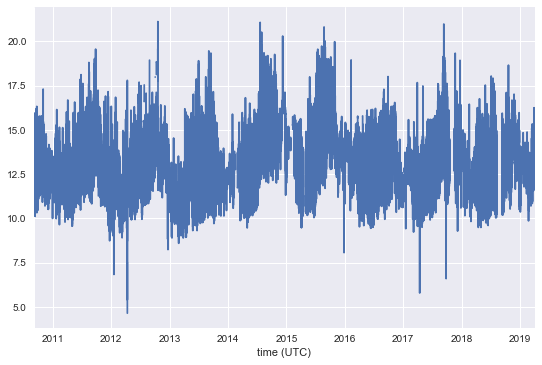

In [151]:
df_mlml_t = df_mlml.resample('1H').nearest(limit=5) # Resample to hourly
df_mlml_t['seawater_temp_C'].plot()
df_mlml_t['dateTime'] = df_mlml_t.index

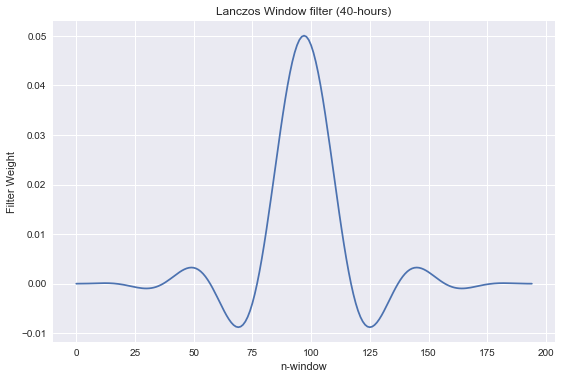

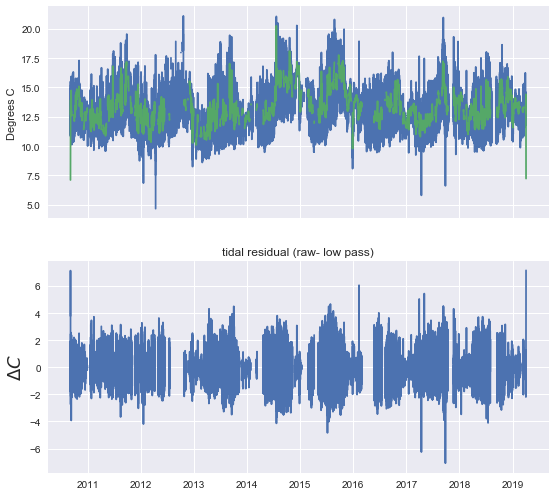

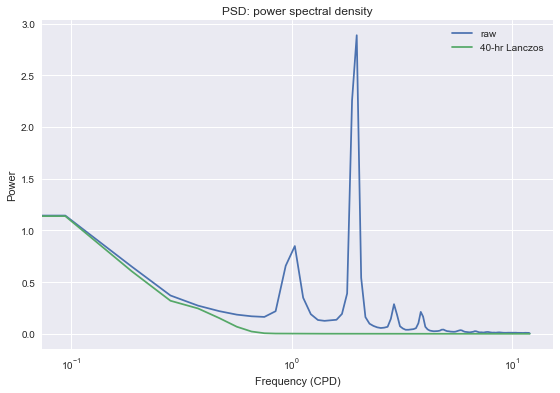

In [152]:
# 40 hour low pass filter
wt = filters.lanc(48+1+48, 1/40.) # Lanczos filter 
df_mlml_t['low_pass_temp'] = np.convolve(wt, df_mlml_t['seawater_temp_C'].values, mode='same')
fig, ax = plt.subplots()
ax.plot(wt) # Plot Filter window
ax.set_title('Lanczos Window filter (40-hours)')
ax.set_ylabel('Filter Weight')
ax.set_xlabel('n-window')

fig, (ax, ax2) = plt.subplots(2,sharex=True)
fig.set_size_inches(8,8)
ax.plot(df_mlml_t['seawater_temp_C'])
ax.plot(df_mlml_t['low_pass_temp'])
# ax.set_ylim(8,13)
# ax.set_xlim('2013-2-1','2013-8-28')
ax.set_ylabel('Degrees C')
ax2.plot(df_mlml_t['seawater_temp_C'] - df_mlml_t['low_pass_temp'])
ax2.set_title('tidal residual (raw- low pass)')
ax2.set_ylabel('$\Delta C$',size=18)
sig = df_mlml_t['seawater_temp_C'].dropna().values # remove all NaNs
freqs, psd = signal.welch(sig,fs=24)
fig,(ax) = plt.subplots()
ax.semilogx(freqs, psd,label='raw')
plt.xlabel('Frequency (CPD)')
plt.ylabel('Power')
plt.tight_layout()
sig = df_mlml_t['low_pass_temp'].dropna().values # remove all NaNs
freqs, psd = signal.welch(sig,fs=24)
ax.semilogx(freqs, psd,label='40-hr Lanczos')
plt.title('PSD: power spectral density')
plt.legend()

__Santa Cruz Wharf__

`erddap_id = "edu_ucsc_scwharf1"`

In [154]:
dataset_id = "edu_ucsc_scwharf1"
df_sc = get_erddap_data(dataset_id)

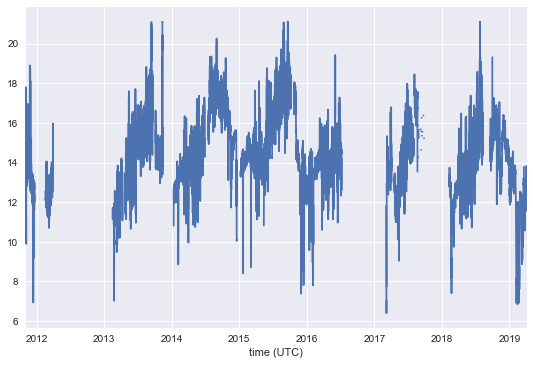

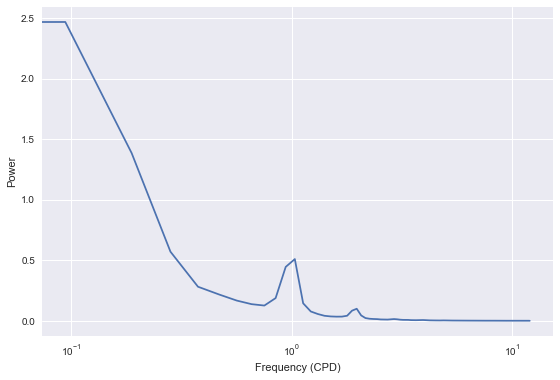

In [164]:
df_sc_t = df_sc.resample('1H').nearest(limit=5) # Resample to hourly
df_sc_t['seawater_temp_C'].plot()
df_sc_t['dateTime'] = df_sc_t.index
sig = df_sc_t['seawater_temp_C'].dropna().values # remove all NaNs
freqs, psd = signal.welch(sig,fs=24)
fig,(ax) = plt.subplots()
ax.semilogx(freqs, psd,label='raw')
plt.xlabel('Frequency (CPD)')
plt.ylabel('Power')
plt.tight_layout()
# # sig = df_sc['low_pass_temp'].dropna().values # remove all NaNs
# # freqs, psd = signal.welch(sig,fs=24)
# # ax.semilogx(freqs, psd,label='40-hr Lanczos')
# # plt.title('PSD: power spectral density')
# # plt.legend()

In [79]:
ix = np.where(np.isfinite(cdip_daily['seawater_temp_C']))

In [24]:
kw = {
    'standard_name': 'sea_water_temperature',
    'time>=': '2010-07-10T00:00:00Z',
    'time<=': '2019-02-10T00:00:00Z',
    'min_lon': -123.0,
    'max_lon': -121.5,
    'min_lat': 36.0,
    'max_lat': 37.0,
}
search_url = e.get_search_url(response='html', **kw)
# pd.read_csv(search_url)['Dataset ID']
show_iframe(search_url)

/anaconda3/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")
